# Process base variables

## Import Libraries

In [1]:
import numpy as np
import glob
import os
from cdo import Cdo
import sys
import subprocess as sp
import intake
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm 
import xarray as xr
import pandas
import re

import plotting_helpers as ph

sys.path.append("/home/u/u301557/UHH-CMIP6/scripts")
from functions.FUNC_CreateModellist import MODELLIST
from functions.FUNC_CreateModellist import MODELLIST_from_list

sys.path.append("/home/u/u301557/UHH-Sat-SIA/scripts")
from functions.logger_functions import *

cdo = Cdo()
#os.system('module load nco')
#os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

print("DONE")

DONE


## Set Paths

In [2]:
outpath        = f"/work/uo1227/u301557/ArcticCarbon/data/"            # test outpath

#gridpath       = '/work/uo1227/DATA/modelling/CMIP6/gridareas/'                   # where the gridarea files are strored
gridpath       = '/work/uo1227/u301557/ArcticCarbon/data/gridarea/'
temppath       = '/work/uo1227/u301557/temp/'                                     # temporary strorage for "mergetime"    
ocean_maskpath = "/work/uo1227/u301557/ArcticCarbon/data/ocean-masks-remap/"
AO_mask        = "/home/u/u301557/ArcticCarbon/Arctic_ocean_mask_regions.nc"

## Intake Search

In [3]:
import intake
col = intake.open_esm_datastore("/work/ik1017/Catalogs/dkrz_cmip6_disk.json")

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/intake_esm/cat.py:264: DtypeWarning: Columns (21,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [13]:
def most_frequent(lst):
  """Finds the most frequent element in a list.

  Args:
    lst: A list of elements.

  Returns:
    The most frequent element in the list.
  """

  freq_counter = {}
  for item in lst:
    freq_counter[item] = freq_counter.get(item, 0) + 1

  max_freq = 0
  most_frequent_item = None
  for item, freq in freq_counter.items():
    if freq > max_freq:
      max_freq = freq
      most_frequent_item = item

  return most_frequent_item


In [25]:
def modelsearch(scenario, variable, logger=None, member=None, model=None):
    query = {"experiment_id": scenario, "variable_id": variable, "frequency":"mon"}#, "activity_id":"ScenarioMPI"}

    if scenario[:3] == "ssp":
        query["activity_id"] = "ScenarioMIP"
    if member is not None:
        query["member_id"] = member
    if model is not None:
        query["source_id"] = model
        
    
    df = col.search(**query).df
    try:
        table_id     = most_frequent(df["table_id"])#df["table_id"][0]
        #print()
        activity_id  = df["activity_id"][0]
        modellist = sorted(list(set(df["source_id"])))
        if logger is not None:
            logger.warning("VARIABLE:  " + variable)
            if len(list(set(df["table_id"])))>1:
                logger.warning("more than one table_id:"+ str(set(df["table_id"])))
            logger.info("table_id:  " + table_id)
            logger.info("long_name: " + df["long_name"][0])
            logger.info("units:     " + str(list(set(df["units"]))))
            logger.debug("dummy:    " + df["uri"][0])
            
            ds   = xr.open_dataset(df["uri"][0])
            mean = ds[variable].isel(time=0).mean().values.item()
            ds.close()
            logger.info(f"mean for t=0: {mean}")
            logger.info(" ")
            
    
        modelcenters = {}
        ensemblemembers = {}
        for model in modellist:
            filtered = df[df['source_id'] == model].copy()
            modelcenters[model] = list(set(filtered["institution_id"]))[0] # <---------------- change for UKESM1-0-LL
            if model == "UKESM1-0-LL":
                modelcenters[model] = "MOHC"
            ensemblemembers[model] = sort_and_filter_cmip6_members(set(filtered["member_id"]))
    except Exception as e:
        logger.warning("Search not successful")
        logger.warning(query)
        logger.warning(" ")
        return None, None, None, None, None

    return activity_id, table_id, modellist, modelcenters, ensemblemembers, 

In [5]:
def sort_and_filter_cmip6_members(members):
  """Sorts CMIP6 ensemble members by 'r' and filters out members with 'i' != 1.

  Args:
    members: A list of CMIP6 ensemble member names.

  Returns:
    A sorted list of CMIP6 ensemble member names.
  """

  def get_ri_values(member):
    match = re.search(r'r(\d+)i(\d+)', member)
    return int(match.group(1)), int(match.group(2)) if match else (0, 0)

  filtered_members = [member for member in members if get_ri_values(member)[1] < 10]
  return sorted(filtered_members, key=lambda x: get_ri_values(x)[0])

In [6]:
logging_level = "debug"
logger = build_terminal_logger(logging_level, logger_name="fgco2")

### Example Search

In [44]:
for variable in ["co2", "fgco2", "nbp", "fLuc", "npp", "rh","ra", "cVeg", "cSoil", "cLitter"]:
    #try:
    activity_id, table_id, modellist, modelcenters, ensemblemembers = modelsearch("historical", variable, logger, model="MPI-ESM1-2-LR")#, member="r1i1p1f1" #     GISS-E2-1-G-CC
    #except Exception as e:
    #    pass

Search not successful
{'experiment_id': 'historical', 'variable_id': 'co2', 'source_id': 'MPI-ESM1-2-LR'}
 
VARIABLE:  fgco2
table_id:  Omon
long_name: Surface Downward Mass Flux of Carbon as CO2 [kgC m-2 s-1]
units:     ['kg m-2 s-1']
dummy:    /work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r10i1p1f1/Omon/fgco2/gn/v20190710/fgco2_Omon_MPI-ESM1-2-LR_historical_r10i1p1f1_gn_185001-186912.nc
mean for t=0: 4.0103526055546013e-10
 
VARIABLE:  nbp
table_id:  Lmon
long_name: Carbon Mass Flux out of Atmosphere Due to Net Biospheric Production on Land [kgC m-2 s-1]
units:     ['kg m-2 s-1']
dummy:    /work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r10i1p1f1/Lmon/nbp/gn/v20190710/nbp_Lmon_MPI-ESM1-2-LR_historical_r10i1p1f1_gn_185001-186912.nc
mean for t=0: -9.436851300392846e-10
 
VARIABLE:  fLuc
table_id:  Emon
long_name: Net Carbon Mass Flux into Atmosphere Due to Land-Use Change [kgC m-2 s-1]
units:     ['kg m-2 s-1']
dummy:    /work/ik1017/CMIP6/data/CMI

In [26]:
for variable in ["co2", "fgco2", "nbp", "fLuc", "npp", "rh","ra", "cVeg", "cSoil", "cLitter"]:
    #try:
    activity_id, table_id, modellist, modelcenters, ensemblemembers = modelsearch("ssp126", variable, logger, model="CESM2")#, member="r1i1p1f1" # MPI-ESM1-2-LR    GISS-E2-1-G-CC
    #except Exception as e:
    #    pass

VARIABLE:  co2
table_id:  Amon
long_name: Mole Fraction of CO2
units:     ['mol mol-1']
dummy:    /work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/NCAR/CESM2/ssp126/r10i1p1f1/Amon/co2/gn/v20200528/co2_Amon_CESM2_ssp126_r10i1p1f1_gn_201501-206412.nc
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'co2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
mean for t=0: 0.000442209595348686
 
VARIABLE:  fgco2
table_id:  Oyr
long_name: Surface Downward Mass Flux of Carbon as CO2 [kgC m-2 s-1]
units:     ['kg m-2 s-1']
dummy:    /work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/NCAR/CESM2/ssp126/r4i1p1f1/Oyr/fgco2/gn/v20200528/fgco2_Oyr_CESM2_ssp126_r4i1p1f1_gn_2015-2064.nc
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/xarray/conventions.py:427: SerializationWarning: variable 'fgco2' has multiple fill values {1e+20, 1e

In [30]:
ds1 = xr.open_dataset("/work/ik1017/CMIP6/data/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r10i1p1f1/Lmon/nbp/gn/v20190710/nbp_Lmon_MPI-ESM1-2-LR_historical_r10i1p1f1_gn_185001-186912.nc")

In [31]:
ds1

<xarray.Dataset>
Dimensions:    (time: 240, bnds: 2, lat: 96, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1869-12-16T12:00:00
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    nbp        (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  164359.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            nbp
    variant_label:          r10i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/2b2bf740-3690-46c9-8c79-647e5f95a105

In [29]:
ds2 = xr.open_dataset("/work/ik1017/CMIP6/data/CMIP6/CMIP/NASA-GISS/GISS-E2-1-G/historical/r101i1p1f1/Lmon/nbp/gn/v20190815/nbp_Lmon_GISS-E2-1-G_historical_r101i1p1f1_gn_185001-190012.nc")
ds2

<xarray.Dataset>
Dimensions:    (time: 612, bnds: 2, lat: 90, lon: 144)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 1900-12-16 12:00:00
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    nbp        (time, lat, lon) float32 ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                Kenneth Lo (cdkkl@giss.nasa.gov)
    ...                     ...
    title:                  GISS-E2-1-G output prepared for CMIP6
    tracking_id:            hdl:21.14100/218802d9-fca0-42ab-a5c8-7e24fd8274d6
    variable_id:            nbp
    variant_label:          r101i1p1f1
    license:                CMIP6 model data produced by NASA Goddard Institu...
    cmor_version:           3.3.2

In [ ]:
# kg m-2 -> kg (mul cellarea) -> Pg (mul 1e-12)

In [ ]:
#failed to create fgco2_60_IPSL-CM5A2-INCA_r1i1p1f1_historical.nc
#failed to create nbp_60_SAM0-UNICON_r1i1p1f1_historical.nc
#failed to create rh_60_SAM0-UNICON_r1i1p1f1_historical.nc

## Processing Functions

In [7]:
def number_control(files, variable, logger=None):

    file = glob.glob(files)[0]
    in_range = False
    
    ds   = xr.open_dataset(file, decode_times=False)
    mean = ds[variable].isel(time=0).mean().values.item()
    ds.close()
    
    if variable in ["fgco2", "nbp", "fLuc", "npp", "rh","ra"]: # flux
        if mean < 1e-5 and mean > -1e-5:
            in_range = True
        else:
            logger.warning(f"mean for t=0: {mean}")
            logger.warning(f"   {file}")
            
    elif variable in ["cVeg", "cSoil", "cLitter"]: # storage
        if mean < 100 and mean > 1e-3:
            in_range = True
        else:
            logger.warning(f"mean for t=0: {mean}")
            logger.warning(f"   {file}")
    else:
        logger.error(f"Processing not defined for {variable}")
        return None
        
    return in_range

    

In [8]:
def file_existence(filepath, logger):
    filename = filepath.split("/")[-1]
    
    if os.path.isfile(filepath):
        logger.debug("created " + filename)
    else:
        logger.error("failed to create " + filename)

In [9]:
def cal_annual_flux(model, modelcenter, ensemblemember, scenario, variable, table_id, activity_id):
    
    inpath = f"/pool/data/CMIP6/data/{activity_id}/{modelcenter}/{model}/{scenario}/{ensemblemember}/{table_id}/{variable}/" 
    logger.debug(inpath)

    if not len([os.path.basename(x) for x in glob.glob(inpath + '/*')])>0:
        #logger.warning(inpath)
        logger.error(f"Filepath doesn't exsit ({inpath})")
        return
    else:
        gridtype    = [os.path.basename(x) for x in glob.glob(inpath + '/*')][0]
        av_versions = [os.path.basename(x) for x in glob.glob(inpath + gridtype+'/v*')]
        
        if 'v1' in av_versions:
            version = 'v1'
        else:
            version = 'v'+str(np.max([int(v[1::]) for v in av_versions]))
        
        inputfile = f"{inpath}{gridtype}/{version}/*.nc"
    
        # find area file
        try:
            area_file = glob.glob(gridpath + f"{model}_{gridarea_var}_{gridtype}_*")[0]
        except:
            logger.error(f"area file is missing: {gridpath}{model}_{gridarea_var}_{gridtype}_*")
            return
            
        logger.debug(area_file)
        logger.debug(inputfile)
    
        #in_range = number_control(inputfile, variable, logger)
    
        #if in_range:
        correction = ""
        #else:
        #    if variable == "fgco2" and model in ["GISS-E2-1-G", "GISS-E2-1-G-CC"]:
        #        correction = " -divc,1e10"
        #        logger.info("Performing correction")
        #    else:
        #        logger.error(f"No handling for {variable} and {model}")
        #        return
        
        if variable in ["fgco2", "nbp", "fLuc", "npp", "rh","ra"]: # flux
            cdo_cmd = f" -setattribute,{variable}@units='Pg yr-1' -chname,{gridarea_var},{variable}{correction} -divc,1e12 -yearsum -mulc,2592000 -mul {area_file} -mergetime {inputfile}"
        elif variable in ["cVeg", "cSoil", "cLitter"]: # storage
            cdo_cmd = f" -setattribute,{variable}@units='Pg' -chname,{gridarea_var},{variable} -yearmean -divc,1e12 -mul {area_file} -mergetime {inputfile}"
        else:
            logger.error(f"Processing not defined for {variable}")
            return
    
        if earth:
            outfile = outpath +f"{variable}/{variable}_glob_{model}_{ensemblemember}_{scenario}.nc"
            cdo.fldsum(input = cdo_cmd, output=outfile, options ="--reduce_dim")
            file_existence(outfile, logger)
    
        if N60: # Arctic above 60°N
            outfile = outpath +f"{variable}/{variable}_N60_{model}_{ensemblemember}_{scenario}.nc"
            cdo.fldsum(input = " -masklonlatbox,0,360,60,90" + cdo_cmd, output=outfile, options ="--reduce_dim")
            file_existence(outfile, logger)
    
        if masked:
            remapped_mask = ocean_maskpath + f"{model}_arctic-ocean-mask_remapped.nc"
            if not os.path.isfile(remapped_mask):
                examplefile = glob.glob(inputfile)[0]        
                cdo.copy(input = f" -remapbil,{area_file} -selvar,arctic_mask {AO_mask}", output=remapped_mask)
                file_existence(remapped_mask, logger)
         
            logger.debug(remapped_mask)
    
            outfile = outpath +f"{variable}/{variable}_masked_{model}_{ensemblemember}_{scenario}.nc"
            cdo.fldsum(input = f" -ifthen {remapped_mask}" + cdo_cmd, output=outfile, options ="--reduce_dim")
            file_existence(outfile, logger)


## Processing Loop

In [28]:
logging_level = "warning"
logger = build_terminal_logger(logging_level, logger_name="fgco2")

In [29]:
earth  = True
masked = False
N60    = True

for variable in ["fgco2", "nbp", "fLuc", "npp", "rh", "ra", "cVeg", "cSoil"]: #
    gridarea_var = "areacello" if variable == "fgco2" else "areacella"
    
    for scenario in ["historical", "ssp126", "ssp245", "ssp370", "ssp585"]:#"historical", "ssp126", "ssp245", "ssp370", "ssp585"]:
        logger.info(scenario)
        activity_id, table_id, modellist, modelcenters, ensemblemembers = modelsearch(scenario, variable, logger, member=None)

        #print(table_id)
        
        for model in tqdm(modellist, leave=True):
            logger.info(model)
            for ensemblemember in ensemblemembers[model][:1]:
                outputfile = f"{outpath}{variable}/{variable}_N60_{model}_{ensemblemember}_{scenario}.nc"
                if os.path.isfile(outputfile):
                    logger.debug(f"--- File already exists ({ensemblemember}).")
                    pass
                else:
                    logger.info("... "+ensemblemember)
                    cal_annual_flux(model, modelcenters[model], ensemblemember, scenario, variable, table_id, activity_id)

VARIABLE:  fgco2
  0%|          | 0/29 [00:00<?, ?it/s]area file is missing: /work/uo1227/u301557/ArcticCarbon/data/gridarea/BCC-CSM2-MR_areacello_gn_*
area file is missing: /work/uo1227/u301557/ArcticCarbon/data/gridarea/BCC-ESM1_areacello_gn_*
failed to create fgco2_N60_IPSL-CM5A2-INCA_r1i1p1f1_historical.nc
100%|██████████| 29/29 [00:02<00:00, 13.33it/s]
VARIABLE:  fgco2
  0%|          | 0/16 [00:00<?, ?it/s]area file is missing: /work/uo1227/u301557/ArcticCarbon/data/gridarea/BCC-CSM2-MR_areacello_gn_*
failed to create fgco2_N60_IPSL-CM6A-LR_r1i1p1f1_ssp126.nc
100%|██████████| 16/16 [00:14<00:00,  1.12it/s]
VARIABLE:  fgco2
100%|██████████| 18/18 [00:16<00:00,  1.10it/s]
VARIABLE:  fgco2
100%|██████████| 17/17 [00:15<00:00,  1.09it/s]
VARIABLE:  fgco2
100%|██████████| 19/19 [00:25<00:00,  1.35s/it]
VARIABLE:  nbp
 82%|████████▏ | 27/33 [00:00<00:00, 43.82it/s]failed to create nbp_glob_SAM0-UNICON_r1i1p1f1_historical.nc
failed to create nbp_N60_SAM0-UNICON_r1i1p1f1_historical.nc
100

# Combine Base Variables

In [30]:
def modellist_from_files(files, split_chr="_", split_num=-3):
    modellist = []
    for file in files:
        model = file.split(split_chr)[split_num]
        modellist.append(model)
    return set(modellist)
        

In [31]:
def simple_cdo_operation(var1, var2, res, operation, outpath, regions=["glob"], scenarios=["historical"]):
    if not operation in ["add", "sub"]:
        logger.error("Wrong operation. Has to be either add or sub")
        return
    else:
        for region in regions:
            for scenario in scenarios:
                
                # Find models that have files for both variables
                files1    = sorted(glob.glob(outpath + f"{var1}/{var1}*{region}*{scenario}.nc"))
                files2    = sorted(glob.glob(outpath + f"{var2}/{var2}*{region}*{scenario}.nc"))
                modellist = list(modellist_from_files(files1) & modellist_from_files(files2))
                logger.info(modellist)
                
                for model in modellist[:]:
                    logger.info(model)
                    files1 = sorted(glob.glob(outpath + f"{var1}/{var1}*{region}*{model}_*{scenario}.nc"))
                    for file1 in files1:
                        member   = file1.split("_")[-2]
                        logger.debug(file1)
                    
                        outputfile = outpath + f"{res}/{res}_{region}_{model}_{member}_{scenario}.nc"
                        file2      = outpath + f"{var2}/{var2}_{region}_{model}_{member}_{scenario}.nc"
                        if not os.path.isfile(outputfile):
                            if os.path.isfile(file2):
                                cdo.copy(input = f"-chname,{var1},{res} -{operation}  {file1} {file2}", output=outputfile)
                                file_existence(outputfile, logger)
                            else:
                                logger.warning(f"Members don't match for: {model} {member} {scenario}")
                                files2 = glob.glob(outpath + f"{var2}/{var2}*{region}*{model}_*{scenario}.nc")
                                logger.debug(f"   " + str(files2))
                        else:
                            logger.debug("--- File already exists")

In [33]:
# calculate GPP
simple_cdo_operation(var1="npp", var2="ra", res="gpp", operation="add", outpath=outpath, regions=["glob", "N60"], scenarios=["historical", "ssp126", "ssp245", "ssp370", "ssp585"])

# calculate NEP
simple_cdo_operation(var1="npp", var2="rh", res="nep", operation="sub", outpath=outpath, regions=["glob", "N60"], scenarios=["historical", "ssp126", "ssp245", "ssp370", "ssp585"])

# calculate terrestrial carbon
simple_cdo_operation(var1="cSoil", var2="cVeg", res="terra_carbon", operation="add", outpath=outpath, regions=["glob", "N60"], scenarios=["historical", "ssp126", "ssp245", "ssp370", "ssp585"])

Members don't match for: CESM2-WACCM-FV2 r1i1p1f1 historical
Members don't match for: GISS-E2-1-H r1i1p1f1 historical
Members don't match for: CanESM5 r2i1p1f1 ssp126
Members don't match for: CanESM5 r2i1p2f1 ssp126
Members don't match for: CanESM5-CanOE r2i1p2f1 ssp126
Members don't match for: CanESM5 r2i1p1f1 ssp245
Members don't match for: CanESM5-CanOE r3i1p2f1 ssp245
Members don't match for: GISS-E2-1-G r1i1p1f2 ssp370
Members don't match for: CanESM5 r1i1p2f1 ssp585
Members don't match for: IPSL-CM6A-LR r2i1p1f1 ssp585
Members don't match for: CESM2-WACCM-FV2 r1i1p1f1 historical
Members don't match for: GISS-E2-1-H r1i1p1f1 historical
Members don't match for: CanESM5 r2i1p1f1 ssp126
Members don't match for: CanESM5 r2i1p2f1 ssp126
Members don't match for: CanESM5-CanOE r2i1p2f1 ssp126
Members don't match for: CanESM5 r2i1p1f1 ssp245
Members don't match for: CanESM5-CanOE r3i1p2f1 ssp245
Members don't match for: GISS-E2-1-G r1i1p1f2 ssp370
Members don't match for: CanESM5 r1i1p2f1

# Error investigation

In [63]:
remapped_mask = "/work/uo1227/u301557/ArcticCarbon/data/ocean-masks-remap/MIROC-ES2L_arctic-ocean-mask_remapped.nc"
area_file     = "/work/uo1227/DATA/modelling/CMIP6/gridareas/MIROC-ES2L_areacello_gn_calc.nc"
inputfile     = "/pool/data/CMIP6/data/CMIP/MIROC/MIROC-ES2L/historical/r1i1p1f2/Omon/fgco2/gr1/v20200731/*.nc"

#cdo.fldsum(input = f" -ifthen {remapped_mask} -setattribute,fgco2@units='Pg yr-1' -chname,areacello,fgco2 -divc,1e12 -yearsum -mulc,2592000 -mul {area_file} -mergetime {inputfile}", output=f"test.nc", options ="--reduce_dim")
cdo.fldsum(input = f" -ifthen {remapped_mask} -setattribute,fgco2@units='Pg yr-1' -chname,areacello,fgco2 -divc,1e12 -yearsum -mulc,2592000 -mergetime {inputfile}", output=f"test.nc", options ="--reduce_dim")

#cdo.mul(area_file, input = f" -mul {area_file} -mergetime {inputfile}", output=f"test.nc", options ="--reduce_dim")
#output = cdo.mul(area_file+" "+inputfile, output="test.nc", options="--reduce_dim")

file_existence("test.nc", logger)

created test.nc


In [60]:
import subprocess
file = glob.glob(inputfile)[0]
command = f"cdo mul {remapped_mask} {file} test.nc"
output = subprocess.check_output(command, shell=True, text=True)


cdo    mul (Abort): Grid size of the input parameter arctic_mask do not match!


CalledProcessError: Command 'cdo mul /work/uo1227/u301557/ArcticCarbon/data/ocean-masks-remap/MIROC-ES2L_arctic-ocean-mask_remapped.nc /pool/data/CMIP6/data/CMIP/MIROC/MIROC-ES2L/historical/r1i1p1f2/Omon/fgco2/gr1/v20200731/fgco2_Omon_MIROC-ES2L_historical_r1i1p1f2_gr1_185001-201412.nc test.nc' returned non-zero exit status 1.

# Look at Files

In [87]:
files_60 = sorted(glob.glob(outpath + "*60*.nc"))
#files_AO = glob.glob(outpath + "*AO*.nc")

In [88]:
def files_to_dataframe(files, var):
    years = np.arange(1850, 2015)
    df = pd.DataFrame({"year":years})#
    
    for file in files:
        try:
            model = file.split("/")[-1].split("_")[-3]
            ds = xr.open_dataset(file)
            df[model] = ds[var].values
            ds.close()
        except Exception as e:
            print(e)
    
    df = df.set_index("year")

    return df

In [89]:
df_60 = files_to_dataframe(files_60, var)
#df_AO = files_to_dataframe(files_AO)

In [69]:
len(df_60.columns)

32

In [90]:
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in np.linspace(0, 1, len(df_60.columns))]
color_models = {}
for model, color in zip(df_60.columns, colors):
    print(color)
    color_models[model] = color

27
13
Length of values (180) does not match length of index (165)
32


([<matplotlib.axis.XTick at 0x7ffe5db390c0>,
 [Text(0, 0, 'fgco2'),
  Text(1, 0, 'fLuc'),
  Text(2, 0, 'nbp'),
  Text(3, 0, 'npp'),
  Text(4, 0, 'rh'),
  Text(5, 0, 'ra')])

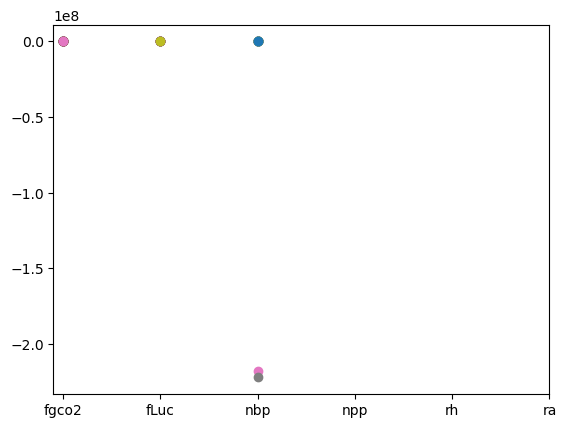

In [92]:
for i,var in enumerate(["fgco2", "fLuc", "nbp"]):#, "npp", "rh","ra"]):
    files_60 = sorted(glob.glob(outpath + f"{var}/{var}*glob*.nc"))
    print(len(files_60))
    df_60 = files_to_dataframe(files_60, var)
    for model, value in df_60.loc[2005:2014].mean(axis=0).items():
        plt.scatter(i, value)

plt.xticks(range(6), ["fgco2", "fLuc", "nbp", "npp", "rh","ra"])

#plt.ylim(-1,6)

In [33]:
files = sorted(glob.glob(outpath + f"fLuc/fLuc*glob*.nc"))
for file in files:
    print(file.split("/")[-1].split("_")[-3])

AWI-ESM-1-1-LR
CESM2-FV2
CESM2-WACCM-FV2
CESM2-WACCM
CESM2
CNRM-ESM2-1
IPSL-CM6A-LR
MPI-ESM-1-2-HAM
MPI-ESM1-2-LR
NorCPM1
NorESM2-MM
TaiESM1
UKESM1-0-LL


In [ ]:
fig, axs = plt.subplots(2,4, tight_layout=True)

for ax,var in zip(axs.flatten(),["fgco2", "fLuc", "nbp", "npp", "rh","ra", "cSoil","cVeg"]):#]):
    files_60 = sorted(glob.glob(outpath + f"{var}/{var}*glob*.nc"))
    print(var, len(files_60))
    df_60 = files_to_dataframe(files_60, var)
    for model in df_60.columns:
        if df_60[model].max() > 1000:
            print(model)
        elif df_60[model].min() < -1000:
            print(model)
        if not model in ["GISS-E2-1-G", "GISS-E2-1-G-CC", "GISS-E2-1-H", "E3SM-1-1-ECA", "E3SM-1-1"]:
            ax.plot(df_60.index, df_60[model])
    ax.set_title(var)
axs[0,2].set_ylim(-10,10)
#plt.xticks(range(6), ["fgco2", "fLuc", "nbp", "npp", "rh","ra"])

#plt.ylim(-1,6)

In [83]:
ds.time[0].values.item()

cftime.DatetimeNoLeap(1850, 7, 1, 6, 0, 0, 0, has_year_zero=True)

fgco2 27
CMCC-ESM2
CanESM5
fLuc 13
nbp 33
GISS-E2-1-G
GISS-E2-1-H
npp 25
rh 24
ra 31
gpp 22
nep 16


(-0.1, 1.0)

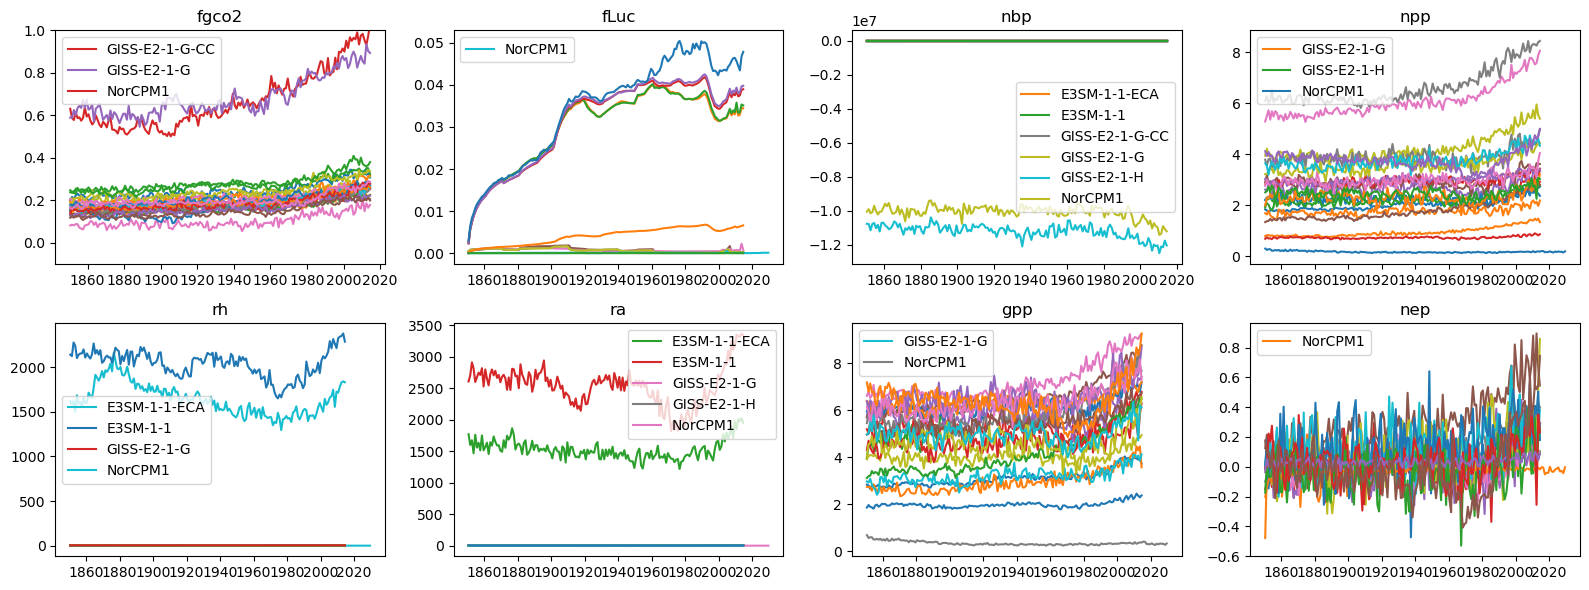

In [93]:
fig, axs = plt.subplots(2,4, tight_layout=True, figsize=(16,6))

for ax,var in zip(axs.flatten(),["fgco2", "fLuc", "nbp", "npp", "rh","ra", "gpp","nep"]):#]):
    files = sorted(glob.glob(outpath + f"{var}/{var}*N60*.nc"))
    print(var, len(files))
    for file in files:
        model = file.split("/")[-1].split("_")[-3]
        #try:
        ds = xr.open_dataset(file)
        
        if ds[var].max() > 10000:
            print(model)
        elif ds[var].min() < -10000:
            print(model)
        if not model in ["GISS-E2-1-G", "GISS-E2-1-G-CC", "GISS-E2-1-H", "E3SM-1-1-ECA", "E3SM-1-1", "NorCPM1"]: # nor bis 2029
            #pass
            ax.plot(ds.time, ds[var])
        else:
            ax.plot(ds.time.values.astype('datetime64[ns]'), ds[var], label=model)
        #except Exception as e:
         #   print(model, e)
    ax.set_title(var)
    ax.legend()
#axs[0,2].set_ylim(-1,2)
axs[0,0].set_ylim(-0.1,1)
#plt.xticks(range(6), ["fgco2", "fLuc", "nbp", "npp", "rh","ra"])

#plt.ylim(-1,6)

In [84]:
ds1

<xarray.Dataset>
Dimensions:    (time: 240, bnds: 2, lat: 96, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 1869-12-16T12:00:00
  * lat        (lat) float64 -88.57 -86.72 -84.86 -83.0 ... 84.86 86.72 88.57
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    nbp        (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  164359.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-LR output prepared for CMIP6
    variable_id:            nbp
    variant_label:          r10i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/2b2bf740-3690-46c9-8c79-647e5f95a105

In [ ]:
ds[var]

cVeg 26
E3SM-1-1-ECA
E3SM-1-1
cSoil 20
nbp 32
GISS-E2-1-G
GISS-E2-1-H
fgco2 27


(-4.0, 10.0)

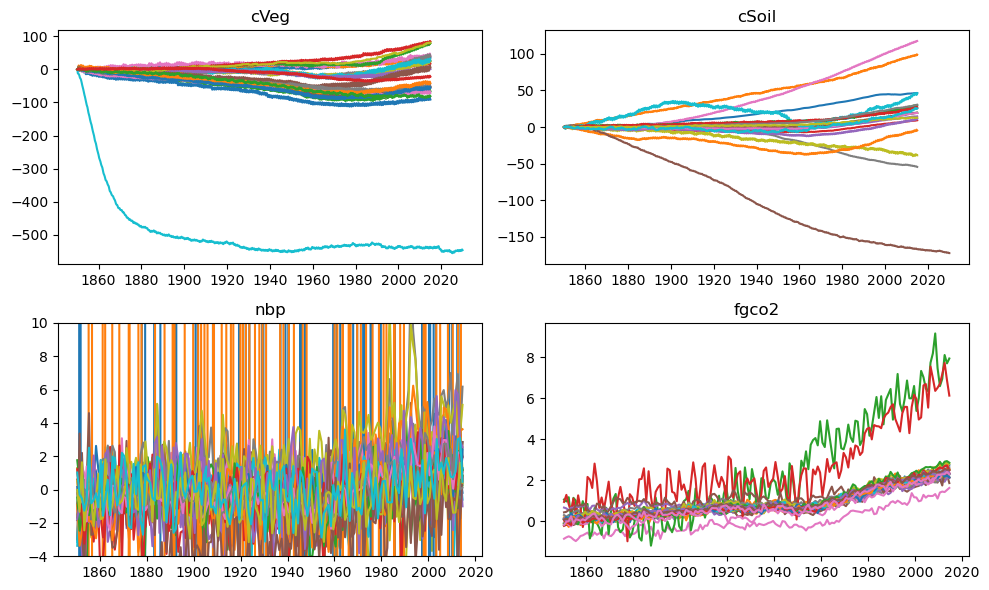

In [19]:
fig, axs = plt.subplots(2,2, tight_layout=True, figsize=(10,6))


for ax,var in zip(axs.flatten(),["cVeg", "cSoil", "nbp", "fgco2"]):#]):
    files = sorted(glob.glob(outpath + f"{var}/{var}*glob*.nc"))
    print(var, len(files))
    for file in files:
        model = file.split("/")[-1].split("_")[-3]
        #try:
        ds = xr.open_dataset(file)
        
        if ds[var].max() > 10000:
            print(model)
        elif ds[var].min() < -10000:
            print(model)

        else:
            if var in ["cVeg", "cSoil"]:
                #print(ds.time.values[:5])
                ax.plot(ds.time, ds[var]-ds[var][0], label=model) # !!!!!!!!!!!!!!!!!! Achtung noch monthly values
            else:
                ax.plot(ds.time, ds[var], label=model)
        #if not model in ["GISS-E2-1-G", "GISS-E2-1-G-CC", "GISS-E2-1-H", "E3SM-1-1-ECA", "E3SM-1-1", "NorCPM1"]: # nor bis 2029
            #pass
            #ax.plot(ds.time, ds[var])
        #else:
         #   ax.plot(ds.time.values.astype('datetime64[ns]'), ds[var], label=model)
        #except Exception as e:
         #   print(model, e)
    ax.set_title(var)
    #ax.legend()
#axs[0,2].set_ylim(-1,2)
axs[1,0].set_ylim(-4,10)
#plt.xticks(range(6), ["fgco2", "fLuc", "nbp", "npp", "rh","ra"])

#plt.ylim(-1,6)

In [ ]:
ds1 = xr.Dataset(
    {
        "temp": (("time", "z"), temp_bin_mean),
        "theta": (("time", "z"), theta),
        "temp_std": (("time", "z"), temp_bin_std),
        "temp_N": (("time", "z"), temp_bin_N),
        "temp_imet": ("time", imet_df["temp"].values),
        "pres_imet": ("time", imet_df["pres"].values),
        "lat_imet": ("time",  imet_df["lat"].values),
        "lon_imet": ("time",  imet_df["lon"].values),
        "altitude_imet": ("time", imet_df["alt"].values),
        "distance": ("time", imet_df["distance"].values),
    },
    coords={"time": timestamps, "z": z},
)

In [27]:
for var in ["fLuc"]: #, "fLuc", "nbp", "npp", "rh","ra", "cSoil","cVeg"
    files = sorted(glob.glob(outpath + f"{var}/{var}*glob*.nc"))
    for file in files:
        ds = xr.open_mfdataset(file)
        print(file)
        print(ds.time.values[0], ds.time.values[-1])

/work/uo1227/u301557/ArcticCarbon/data/fLuc/fLuc_glob_AWI-ESM-1-1-LR_r1i1p1f1_historical.nc
1850-07-01T06:00:00.000000000 2014-07-01T06:00:00.000000000
/work/uo1227/u301557/ArcticCarbon/data/fLuc/fLuc_glob_CESM2-FV2_r1i1p1f1_historical.nc
1850-06-30 06:00:00 2014-06-30 06:00:00
/work/uo1227/u301557/ArcticCarbon/data/fLuc/fLuc_glob_CESM2-WACCM-FV2_r1i1p1f1_historical.nc
1850-06-30 06:00:00 2014-06-30 06:00:00
/work/uo1227/u301557/ArcticCarbon/data/fLuc/fLuc_glob_CESM2-WACCM_r1i1p1f1_historical.nc
1850-06-30 06:00:00 2014-06-30 06:00:00
/work/uo1227/u301557/ArcticCarbon/data/fLuc/fLuc_glob_CESM2_r1i1p1f1_historical.nc
1850-06-30 06:00:00 2014-06-30 06:00:00
/work/uo1227/u301557/ArcticCarbon/data/fLuc/fLuc_glob_CNRM-ESM2-1_r1i1p1f2_historical.nc
1850-07-01T06:00:00.000000000 2014-07-01T06:00:00.000000000
/work/uo1227/u301557/ArcticCarbon/data/fLuc/fLuc_glob_IPSL-CM6A-LR_r5i1p1f1_historical.nc
1850-07-01T06:00:00.000000000 2014-07-01T06:00:00.000000000
/work/uo1227/u301557/ArcticCarbon/dat

In [30]:
df_60

,CanESM5
year,
1850,-3.371419
1851,0.221578
1852,0.729770
1853,-2.932788
1854,-0.940804
...,...
2010,-5.269493
2011,-1.571345
2012,3.072606


In [12]:
print("test")

test


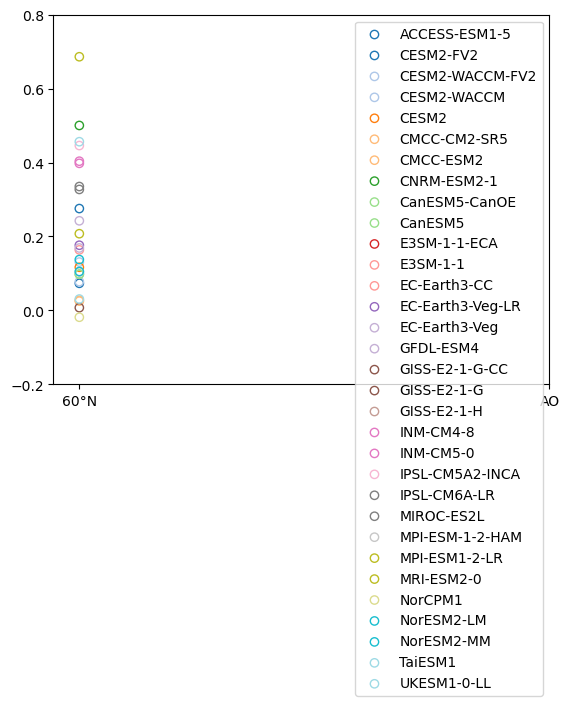

In [45]:
for model, value in df_60.loc[2005:2014].mean(axis=0).items():
    plt.scatter(1, value, facecolors='none', edgecolor=color_models[model], marker="o", label=model)

#for model, value in df_AO.loc[2005:2014].mean(axis=0).items():
#    plt.scatter(2, value, label=model, facecolors='none', edgecolor=color_models[model], marker="o")
 
plt.ylim(-0.2,0.8)
plt.xticks([1,2], ["60°N", "AO"])
plt.legend()

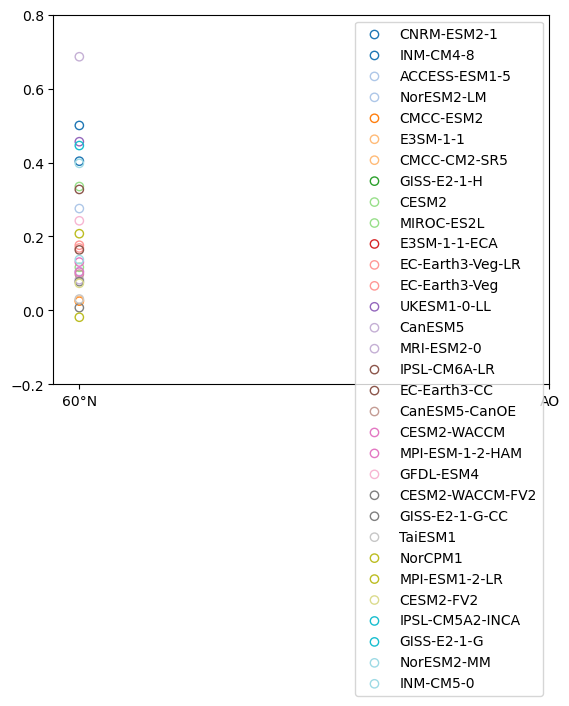

In [74]:
for model, value in df_60.loc[2005:2014].mean(axis=0).items():
    plt.scatter(1, value, facecolors='none', edgecolor=color_models[model], marker="o", label=model)

#for model, value in df_AO.loc[2005:2014].mean(axis=0).items():
#    plt.scatter(2, value, label=model, facecolors='none', edgecolor=color_models[model], marker="o")
 
plt.ylim(-0.2,0.8)
plt.xticks([1,2], ["60°N", "AO"])
plt.legend()

(0.0, 0.5)

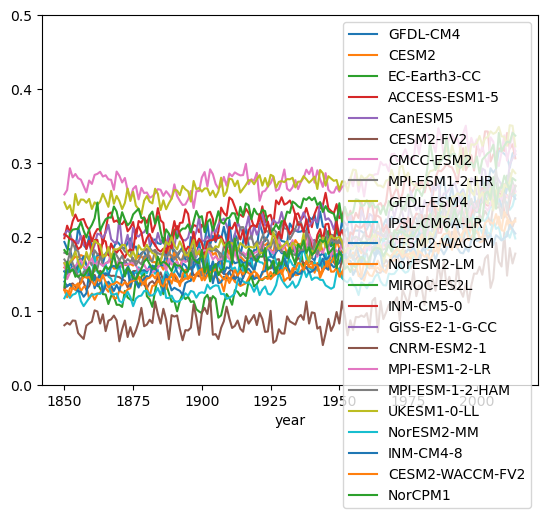

In [54]:
df_60.plot()
plt.ylim(0,0.5)